# Integrating simplified dynamics

In [1]:
using DifferentialEquations
using PyCall
using PyPlot
include("../scripts/AerodynamicsModel.jl")
include("../scripts/Params.jl")
include("../scripts/SphereConeVehicleModel.jl")

entry_vehicle_simplified_dynamics (generic function with 1 method)

## Simplified Dynamics Model
- We assume flat planet model, gravity acceleration is directed along the x axis.
- We assume constant uniform of the atmosphere.
- We assume that the fluid is static.

In [2]:
params = Dict("r_min" => 0.20, # smallest radius of the cone [m]
              "r_max" => 1.30, # largest radius of the cone [m]
              "δ" => 40 / 360 * 2 * pi, # opening angle of the cone [rad]
              "m" => 569.7, # mass of the Phoenix entry system [kg]
              "x_g" => 0.10, # axial center-of-gravity location [m]
              "c" => 1.20, # distance between the radial axis and the cluster of thrusters[m]
              "F_max" => 36.0, # maximum force applied by the thrusters [N]
              "Jxx" => 293.15, # Phoenix entry system [kg.m^2]
              "Jyy" => 184, # Phoenix entry system [kg.m^2]
              "Jzz" => 208.02, # Phoenix entry system [kg.m^2]
              "Jxy" => 0.451, # Phoenix entry system [kg.m^2]
              "Jxz" => -4.424, # Phoenix entry system [kg.m^2] 
              "Jyz" => 0.372, # Phoenix entry system [kg.m^2]
              "g" => 3.711, # Mars gravity [m^2.s^-1]
              "h" => 10800, # Atmospheric Scale Height [m]
              "ρ_0" => 0.020, # Surface density of Mars atmosphere [kg.m^-3]
              "r_p" => 3389.5e3, # Volumetric mean radius of Mars [m]
              "ω_p" => [0, 0, 7.088e-05]) # Angular velocity of Mars [rad.s^-1]
complete_params!(params);

## We integrate the dynamics forward to check for the correctness of the model

## Initial conditions

In [19]:
# Initial conditions

# Iniitial altitude
x_0 = - 125000.0
y_0 = 10.0

# Initial speed
v_0 = 5500 * [1, 0, 0]

# Initial orientation
θ = 0.01 / 360 * 2 * pi
r = tan(θ / 4) .* [0, 0, 1]

# Initial angular rates
ω_0 = zeros(3)

# Initial state
X_0 = [x_0, y_0, 0, r[1], r[2], r[3], v_0[1], v_0[2], v_0[3], ω_0[1], ω_0[2], ω_0[3]]

12-element Array{Float64,1}:
 -125000.0                  
      10.0                  
       0.0                  
       0.0                  
       0.0                  
       4.3633231327548744e-5
    5500.0                  
       0.0                  
       0.0                  
       0.0                  
       0.0                  
       0.0                  

In [20]:
# Iniitial altitude
# Simplified altitude
s_0_dot = X_0[7]

# s_0_dot = X_0[1:3]' * X_0[7:9] / norm(X_0[1:3])

v_0_bar = v_0 / s_0_dot
ω_0_bar = ω_0 / s_0_dot

# Initial state
X_0_bar = [x_0, y_0, 0, r[1], r[2], r[3], v_0_bar[1], v_0_bar[2], v_0_bar[3], ω_0_bar[1], ω_0_bar[2], ω_0_bar[3]]

12-element Array{Float64,1}:
 -125000.0                  
      10.0                  
       0.0                  
       0.0                  
       0.0                  
       4.3633231327548744e-5
       1.0                  
       0.0                  
       0.0                  
       0.0                  
       0.0                  
       0.0                  

## Simplified Dynamics

In [21]:
function open_loop_entry_vehicle_simplified_dynamics!(ẋ, X, params, t)
    u = zeros(12,1)
    entry_vehicle_simplified_dynamics!(ẋ, X, u, params)
end

ẋ = X_0 - X_0
t = 0.0
open_loop_entry_vehicle_simplified_dynamics!(ẋ, X_0, params, t)

12-element Array{Float64,1}:
  5500.0                
     0.0                
     0.0                
     0.0                
     0.0                
     0.0                
 -2365.0415301587664    
     0.15721283039624917
     0.0                
     0.0                
     0.0                
    -0.5834888192821841 

In [22]:
tspan = (0.0, 5.0)
prob = ODEProblem(open_loop_entry_vehicle_simplified_dynamics!, X_0, tspan, params)
sol = solve(prob, abstol=1e-8, reltol=1e-8, saveat=0.1);

In [23]:
function process_solution(sol, params) #r_max, r_min, l, x_g, h, ρ_0, r_p)
    X_sol = hcat(sol.u...)'
    t_sol = sol.t
    num_timesteps = size(t_sol)[1]
    v = X_sol[:, 8:10]
    q = X_sol[:, 4:7]
    
    V_inf = zeros(num_timesteps, 3)
    α = zeros(num_timesteps)
    altitude = zeros(num_timesteps)
    F = zeros(num_timesteps, 3)
    τ = zeros(num_timesteps, 3)
    velocity_norm = zeros(num_timesteps)
    force_norm = zeros(num_timesteps)
    
    for i=1:num_timesteps
        V_inf[i, :] = - qrot(qconj(q[i, :]), v[i, :])
        velocity_norm[i] = norm(v[i, :])
    end
    
    α = atan.(sqrt.(V_inf[:, 2].^2 + V_inf[:, 3].^2) ./ V_inf[:, 1])
    for i=1:num_timesteps
        altitude[i] = norm(X_sol[i, 1:3]) - params["r_p"]
        ρ_inf = params["ρ_0"]

        F_hat = params["F_hat"]
        τ_hat = params["τ_hat"]
        F_a, τ_a = illuminated_aerodynamics_online(F_hat, τ_hat, ρ_inf, V_inf[i, :])

        # Control forces and moments in body_frame
        F_c = zeros(3)
        τ_c = zeros(3)
        # Forces and moments in body-frame
        F[i, :] = F_a + F_c
        τ[i, :] = τ_a + τ_c
        force_norm[i] = norm(F[i, :])
    end
    X_sol = cat(dims=2, X_sol, α) 
    X_sol = cat(dims=2, X_sol, V_inf) 
    X_sol = cat(dims=2, X_sol, F)
    X_sol = cat(dims=2, X_sol, τ)
    X_sol = cat(dims=2, X_sol, altitude)    
    X_sol = cat(dims=2, X_sol, velocity_norm)    
    X_sol = cat(dims=2, X_sol, force_norm)    
    return X_sol, t_sol
end
X_sol, t_sol = process_solution(sol, params) #r_max, r_min, l, x_g, h, ρ_0, r_p);

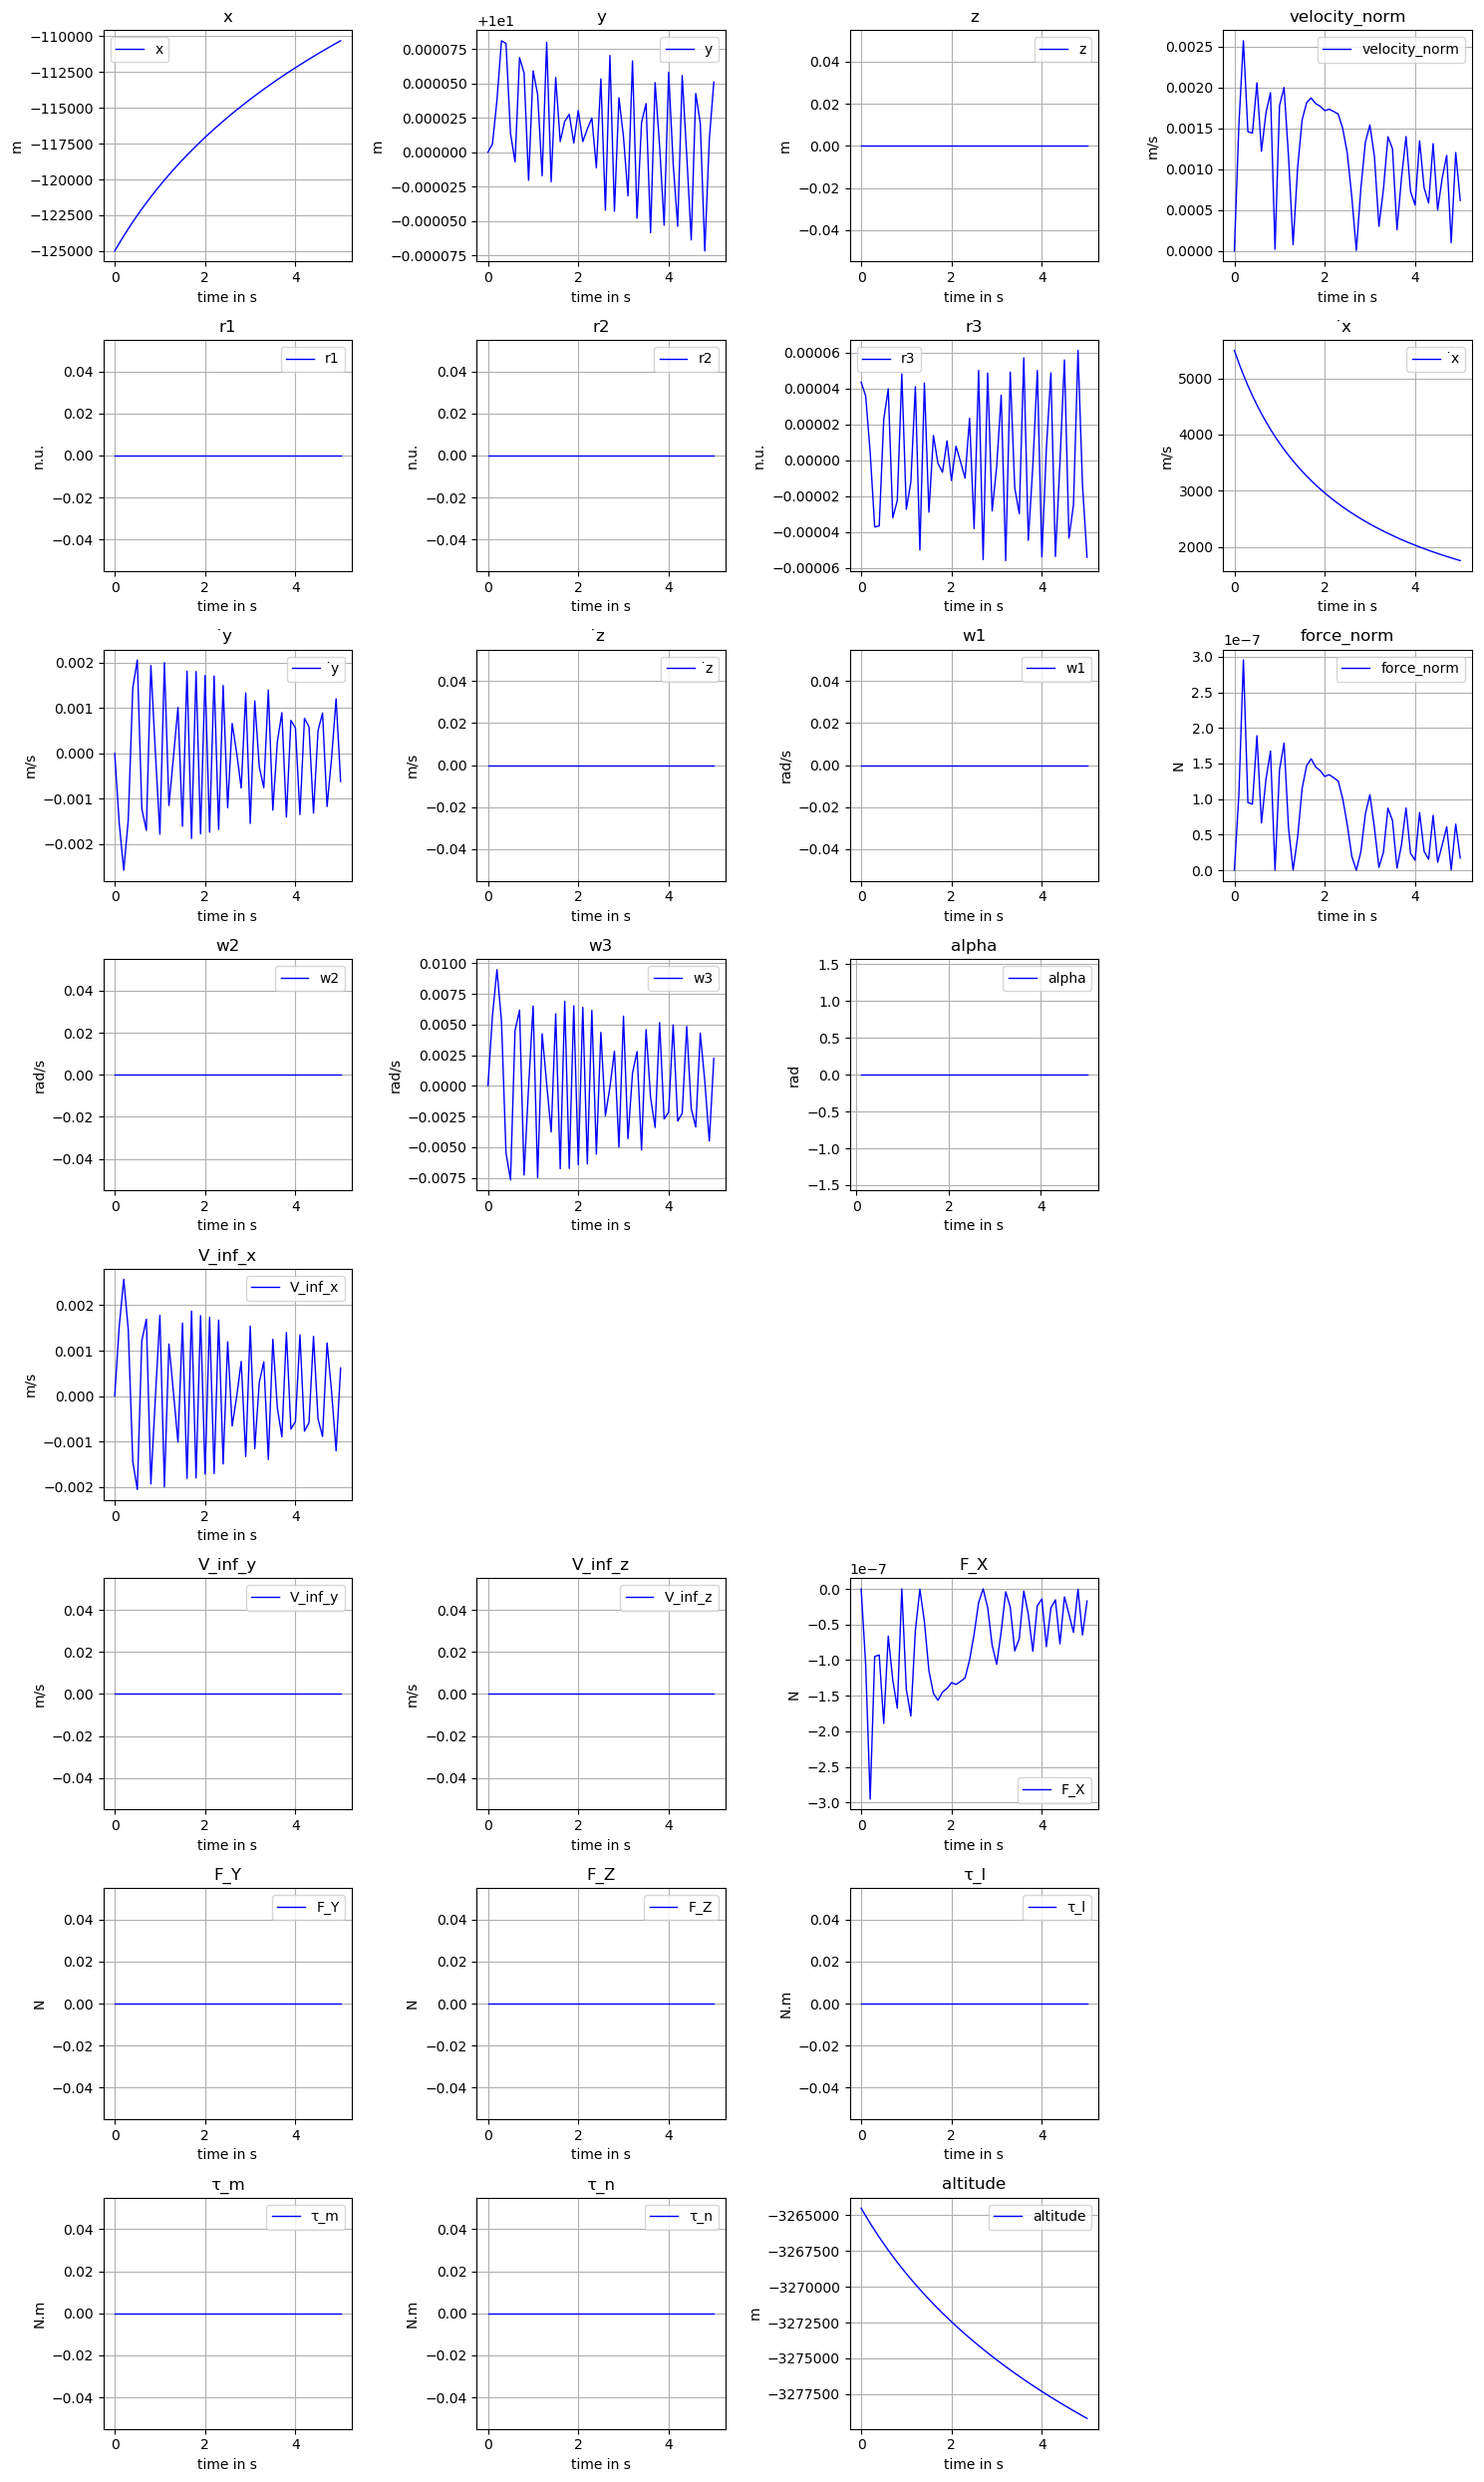

In [24]:
function plot_integrated_dynamics(X_sol, t_sol, params; display=true)
    figure(figsize=(15,25))
    labels = ["x", "y", "z", 
        "r1", "r2", "r3", 
        "̇x", "̇y", "̇z",
        "w1", "w2", "w3", 
        "alpha", 
        "V_inf_x", "V_inf_y", "V_inf_z",
        "F_X", "F_Y", "F_Z",
        "τ_l", "τ_m", "τ_n",
        "altitude", 
        "velocity_norm",
        "force_norm"]
    units = ["m", "m", "m", 
        "n.u.", "n.u.", "n.u.", 
        "m/s", "m/s", "m/s", 
        "rad/s", "rad/s", "rad/s", 
        "rad",
        "m/s", "m/s", "m/s", 
        "N", "N", "N",
        "N.m", "N.m", "N.m", 
        "m",
        "m/s",
        "N"]
    indexes = [1, 2, 3,
        5, 6, 7, 8,
        9, 10, 11,
        13, 14, 15,
        17,
        21, 22, 23,
        25, 26, 27,
        29, 30, 31,
        4,
        12,
        28]
    y_lims = [nothing, nothing, nothing,
#         (-2, 2), (-2, 2), (-2, 2), (-2, 2), 
        nothing, nothing, nothing,
        nothing, nothing, nothing,
        nothing, nothing, nothing,
        (-pi/2, pi/2),
        nothing, nothing, nothing,
        nothing, nothing, nothing, 
        nothing, nothing, nothing,
        nothing, 
        nothing,
        nothing]
    
    for i=1:length(labels)
        Y_sol = X_sol[:, i]
        subplot(8, 4, indexes[i])
        plot(t_sol, Y_sol, color="blue", linewidth=1.0, 
            linestyle="-", label=labels[i])
        legend()
        title(labels[i])
        grid("on")
        xlabel("time in s")
        ylabel(units[i])
        ylim(y_lims[i])     # set the ylim to bottom, top
    end
    if display
        tight_layout() 
        show()
    end
    return
end

plot_integrated_dynamics(X_sol, t_sol, params)

In [25]:
function reparameterize_solution(X, t, s, s_dot)
    x = X[:, 1:3]
    r = X[:, 4:6]
    v = X[:, 7:9]
    ω = X[:, 10:12]
    
    x_bar = x
    r_bar = r
    v_bar = v ./ s_dot
    ω_bar = ω ./ s_dot
    
    X_bar = [x_bar'; r_bar'; v_bar'; ω_bar']'
#     U_bar = U ./ s_dot
    return X_bar, s
end
s_sol = X_sol[:, 1]
s_sol_dot = X_sol[:, 7]
X_sol_bar, s_sol = reparameterize_solution(X_sol, t_sol, s_sol, s_sol_dot)

([-125000.0 10.0 … 0.0 0.0; -1.24461e5 10.0 … 0.0 1.0833e-6; … ; -1.10485e5 10.0 … 0.0 -2.53381e-6; -1.10308e5 10.0001 … 0.0 1.27901e-6], [-125000.0, -1.24461e5, -1.23945e5, -1.23448e5, -1.2297e5, -122509.0, -1.22064e5, -1.21634e5, -1.21218e5, -1.20815e5  …  -1.1199e5, -1.11792e5, -1.11597e5, -111405.0, -1.11216e5, -1.11029e5, -1.10845e5, -1.10663e5, -1.10485e5, -1.10308e5])

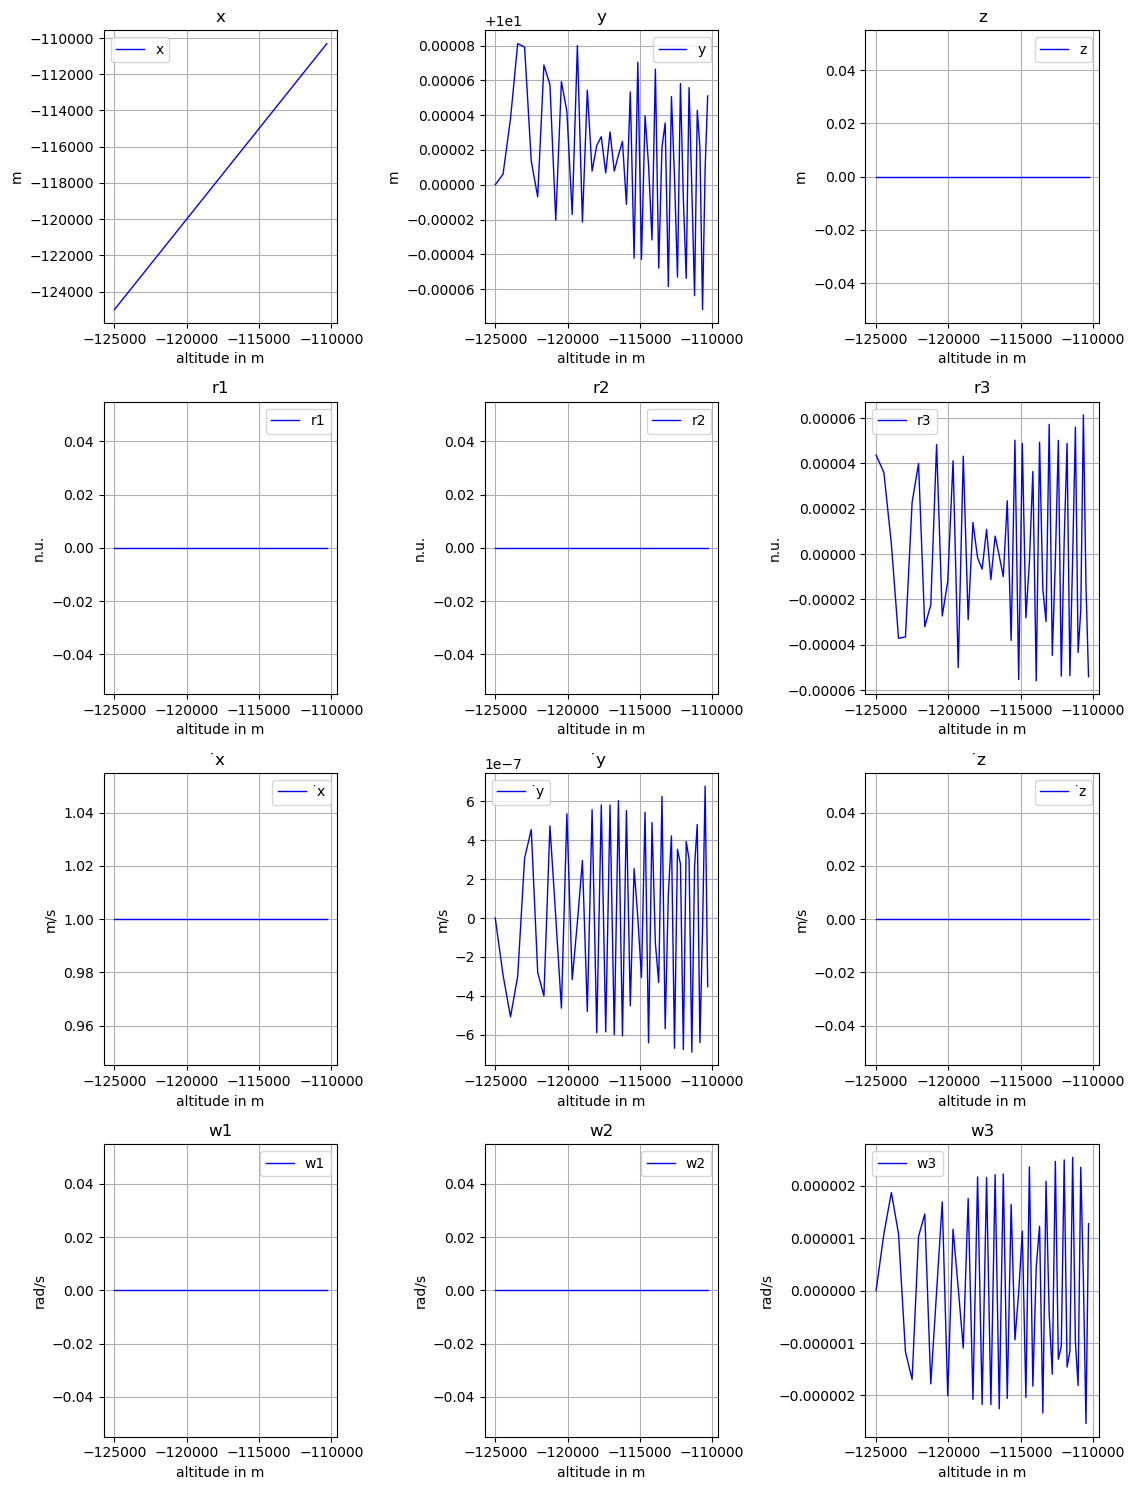

In [26]:
function plot_integrated_dynamics(X_sol, t_sol, params; display=true)
    figure(figsize=(15,15))
    labels = ["x", "y", "z", 
        "r1", "r2", "r3", 
        "̇x", "̇y", "̇z",
        "w1", "w2", "w3"]
    units = ["m", "m", "m", 
        "n.u.", "n.u.", "n.u.", 
        "m/s", "m/s", "m/s", 
        "rad/s", "rad/s", "rad/s"]
    indexes = [1, 2, 3,
        5, 6, 7,
        9, 10, 11,
        13, 14, 15]
    y_lims = [nothing, nothing, nothing,
        nothing, nothing, nothing,
        nothing, nothing, nothing,
        nothing, nothing, nothing]
    
    for i=1:length(labels)
        Y_sol = X_sol[:, i]
        subplot(4, 4, indexes[i])
        plot(t_sol, Y_sol, color="blue", linewidth=1.0, 
            linestyle="-", label=labels[i])
        legend()
        title(labels[i])
        grid("on")
        xlabel("altitude in m")
        ylabel(units[i])
        ylim(y_lims[i])     # set the ylim to bottom, top
    end
    if display
        tight_layout() 
        show()
    end
    return
end

plot_integrated_dynamics(X_sol_bar, s_sol, params)